# TEST sur des images

Fichier: 01d_Complements_image_RGB.ipynb

Essai sur des images.

Commencer par charger l'image de la tulipe en effectuant tout simplement un Fichier-->Ouvrir.

Ensuite, on peut travailler sur l'image en python grace à la librairie PIL


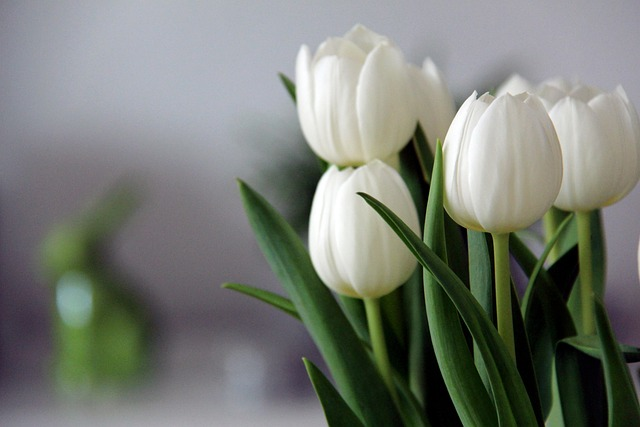

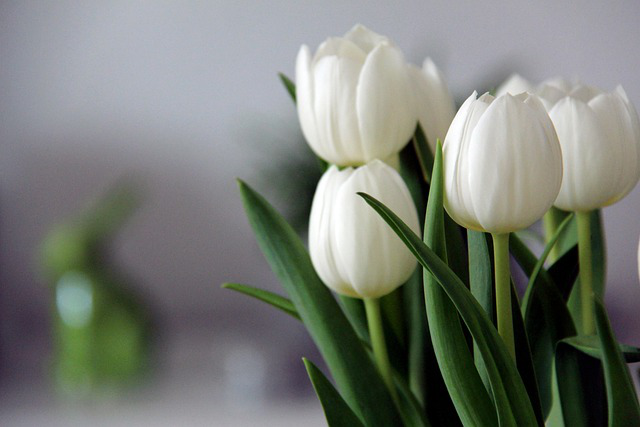

In [12]:
from PIL import Image

img = Image.open("tulipes.jpg")
img


Mode original : RGB -> réduit en mode : P
Couleurs utilisées : 256 / 256


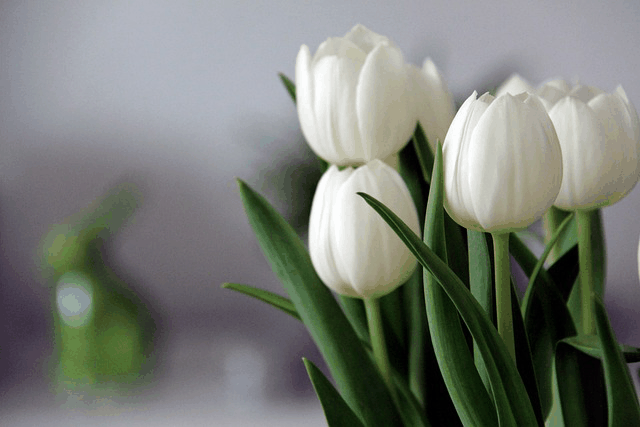

In [32]:
from PIL import Image, ImageDraw
from PIL.Image import Quantize, Dither  # nouvelles constantes

# Charger l’image
img = Image.open("tulipes.jpg").convert("RGB")

# Réduction à 256 couleurs
img256 = img.quantize(
    colors=256,
    method=Quantize.MEDIANCUT,
    dither=Dither.FLOYDSTEINBERG
)

# Vérif
print("Mode original :", img.mode, "-> réduit en mode :", img256.mode)
print("Couleurs utilisées :", len(set(img256.getdata())), "/ 256")

# Affichage de l’image quantifiée
img256



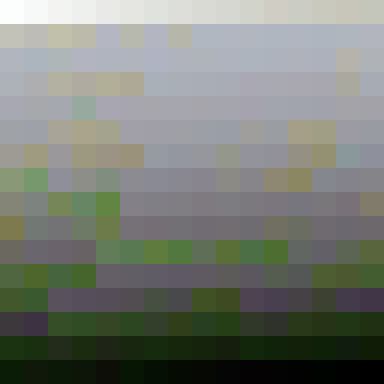

In [33]:
# Palette de 256 couleurs (liste de 768 valeurs R,G,B)
palette = img256.getpalette()

T = 24  # taille d'une case
pal_img = Image.new("RGB", (16*T, 16*T), "white")
draw = ImageDraw.Draw(pal_img)

for i in range(256):
    r, g, b = palette[3*i:3*i+3]
    x = (i % 16) * T
    y = (i // 16) * T
    draw.rectangle([x, y, x+T-1, y+T-1], fill=(r, g, b))

pal_img


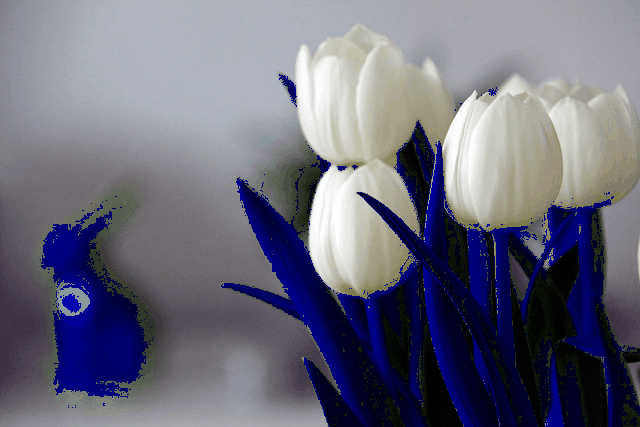

In [39]:
from PIL import Image, ImageDraw
from PIL.Image import Quantize, Dither

# 1) Charger l’image et (si besoin) la réduire à 256 couleurs
img = Image.open("tulipes.jpg").convert("RGB")
img256 = img.quantize(colors=256, method=Quantize.MEDIANCUT, dither=Dither.FLOYDSTEINBERG)

# 2) Récupérer/dupliquer la palette
pal = img256.getpalette()[:]   # 256 * (R,G,B)

# 3) Paramètre simple : "combien le vert doit dominer" pour être considéré comme vert
DELTA = 10   # augmente si trop de pixels changent, baisse si pas assez

# 4) Remplacer les tons verts par des tons bleus (même intensité)
for i in range(256):
    r, g, b = pal[3*i:3*i+3]
    if g - max(r, b) >= DELTA:          # "vert dominant"
        blue_val = g                     # garder l'intensité (on prend le vert comme niveau)
        pal[3*i:3*i+3] = [0, 0, blue_val]

# 5) Appliquer la nouvelle palette et afficher
img256_blue = img256.copy()
img256_blue.putpalette(pal)
img256_blue


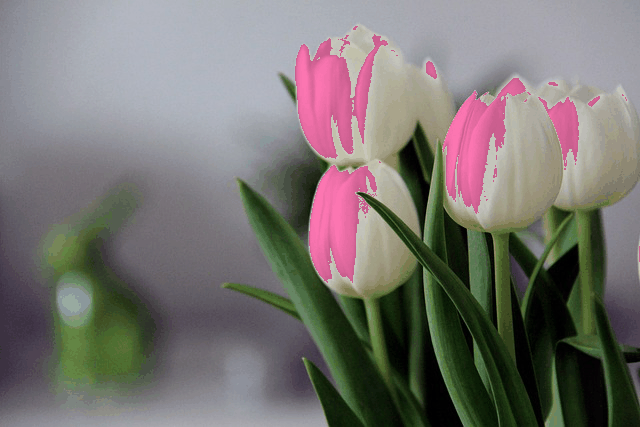

In [37]:
from PIL import Image, ImageDraw
from PIL.Image import Quantize, Dither

# 1) Charger la photo et la réduire à 256 couleurs (si ce n'est pas déjà fait)
img = Image.open("tulipes.jpg").convert("RGB")
img256 = img.quantize(colors=256, method=Quantize.MEDIANCUT, dither=Dither.FLOYDSTEINBERG)

# 2) Récupérer la palette (liste de 256 * 3 valeurs)
pal = img256.getpalette()[:]   # copie

# Réglages (à ajuster selon ta photo)
BRIGHT_MIN = 200   # seuil de "clarté" (0..255) : > → clair
SPREAD_MAX = 30    # seuil de "peu saturé" : max(r,g,b)-min(r,g,b) < → quasi blanc
TARGET_PINK = (255, 120, 180)  # rose de référence (HotPink-ish)

def to_luma(r, g, b):
    # luminance relative (pondérée)
    return int(0.2126*r + 0.7152*g + 0.0722*b)

for i in range(256):
    r, g, b = pal[3*i:3*i+3]
    Y = to_luma(r, g, b)
    spread = max(r, g, b) - min(r, g, b)

    # Détecter une "teinte blanche" dans la palette : très claire & peu saturée
    if Y >= BRIGHT_MIN and spread <= SPREAD_MAX:
        # Conserver la luminosité Y mais la "teinter" en rose :
        # on projette la luminosité sur un rose cible
        scale = Y / 255.0
        nr = int(TARGET_PINK[0] * scale)
        ng = int(TARGET_PINK[1] * scale)
        nb = int(TARGET_PINK[2] * scale)
        pal[3*i:3*i+3] = [nr, ng, nb]

# 3) Appliquer la nouvelle palette (recoloration instantanée)
img256_mod = img256.copy()
img256_mod.putpalette(pal)

# 4) Afficher l'image recolorisée
img256_mod


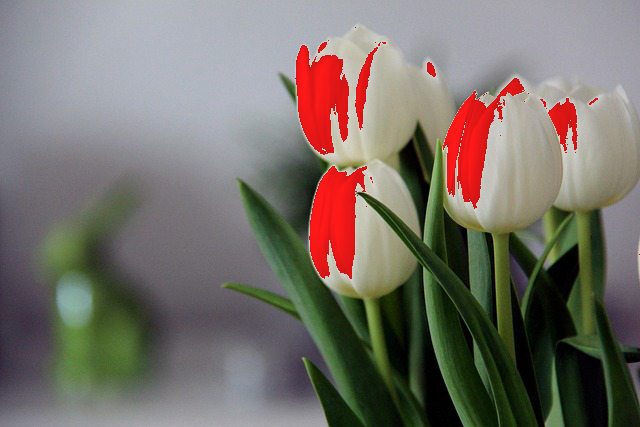

In [26]:
from PIL import Image
import colorsys

# Charge l'image (couleur)
img = Image.open("tulipes.jpg").convert("RGB")
w, h = img.size
out = Image.new("RGB", (w, h))

# Réglages (à ajuster si besoin)
THRESH = 200     # seuil de "proximité du blanc" (0..255)
SAT    = 0.9     # saturation du rouge (0..1, plus grand = rouge plus pur)

for y in range(h):
    for x in range(w):
        r, g, b = img.getpixel((x, y))
        # Détecter "proche du blanc"
        if r > THRESH and g > THRESH and b > THRESH:
            # RGB -> HSV (normalisé 0..1)
            rr, gg, bb = r/255.0, g/255.0, b/255.0
            h0, s0, v0 = colorsys.rgb_to_hsv(rr, gg, bb)
            # Forcer teinte rouge (0), saturation haute, garder la luminosité
            h1 = 0.0
            s1 = SAT
            v1 = v0
            # HSV -> RGB
            r1, g1, b1 = colorsys.hsv_to_rgb(h1, s1, v1)
            out.putpixel((x, y), (int(r1*255), int(g1*255), int(b1*255)))
        else:
            out.putpixel((x, y), (r, g, b))

out


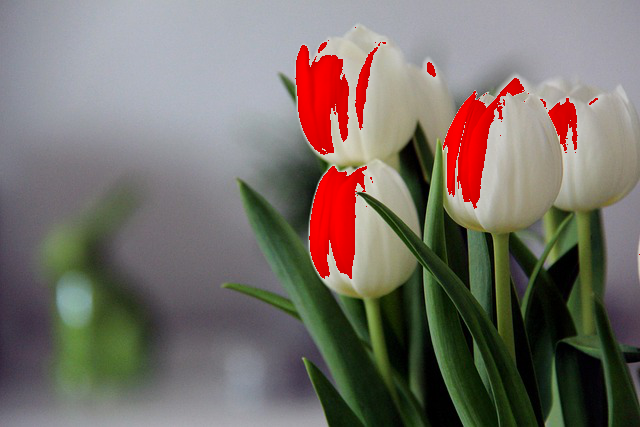

In [28]:
from PIL import Image

img = Image.open("tulipes.jpg").convert("RGB")
w, h = img.size
out = Image.new("RGB", (w, h))

THRESH = 200  # "presque blanc" si r,g,b > THRESH

for y in range(h):
    for x in range(w):
        r, g, b = img.getpixel((x, y))
        if r > THRESH and g > THRESH and b > THRESH:
            I = (r + g + b) // 3           # intensité (0..255)
            out.putpixel((x, y), (I, 0, 0)) # nuance de rouge avec même luminosité
        else:
            out.putpixel((x, y), (r, g, b))

out


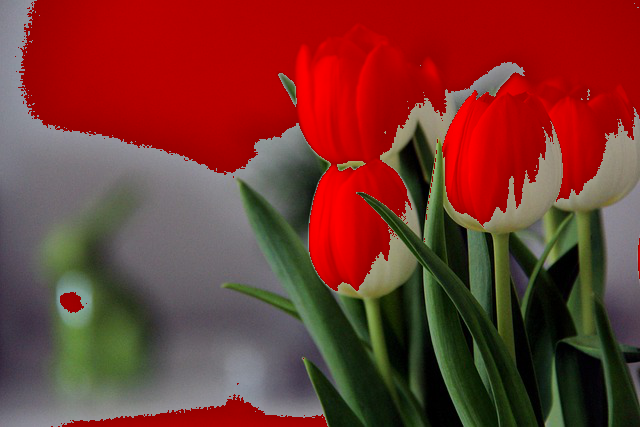

In [30]:
from PIL import Image

img = Image.open("tulipes.jpg").convert("RGB")
w, h = img.size
out = Image.new("RGB", (w, h))

SEUIL = 150  # seuil de luminosité (ajuste entre 120 et 180)

for y in range(h):
    for x in range(w):
        r, g, b = img.getpixel((x, y))
        # Intensité moyenne (luminosité du pixel)
        I = (r + g + b) // 3
        if I > SEUIL:
            # Transformer en nuance de rouge
            out.putpixel((x, y), (I, 0, 0))
        else:
            # Conserver pixel original
            out.putpixel((x, y), (r, g, b))

out


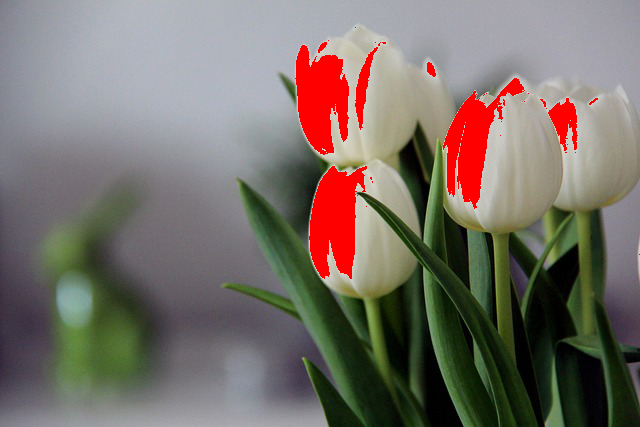

In [24]:
from PIL import Image

# Charger l'image et forcer en mode RGB
img = Image.open("tulipes.jpg").convert("RGB")
largeur, hauteur = img.size

# Nouvelle image résultat
sortie = Image.new("RGB", (largeur, hauteur))

for x in range(largeur):
    for y in range(hauteur):
        r, g, b = img.getpixel((x, y))
        # Détecter si le pixel est "proche du blanc"
        if r > 200 and g > 200 and b > 200:
            # Remplacer par du rouge pur
            sortie.putpixel((x, y), (255, 0, 0))
        else:
            # Garder la couleur originale
            sortie.putpixel((x, y), (r, g, b))

sortie


In [14]:
# Taille et mode de l'image
print("Taille :", img.size)   # (largeur, hauteur)
print("Mode  :", img.mode)   # "RGB"

# Lire un pixel (au centre de l'image)
w, h = img.size
pixel_centre = img.getpixel((w//2, h//2))
print("Pixel au centre :", pixel_centre)  # (R,G,B)

Taille : (640, 427)
Mode  : RGB
Pixel au centre : (251, 254, 247)


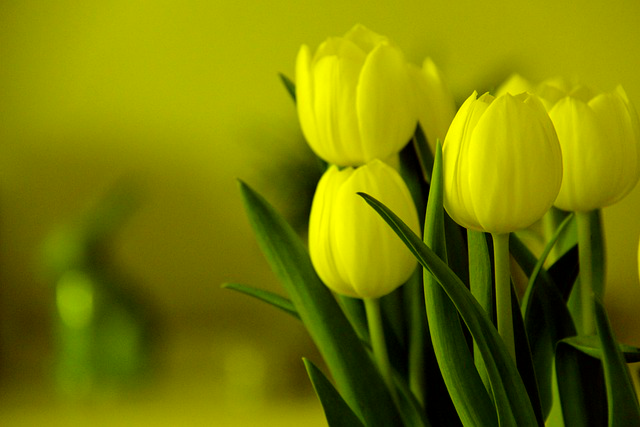

In [19]:
rouge_vert = Image.merge("RGB", (r, g, b.point(lambda _: 0)))
rouge_vert


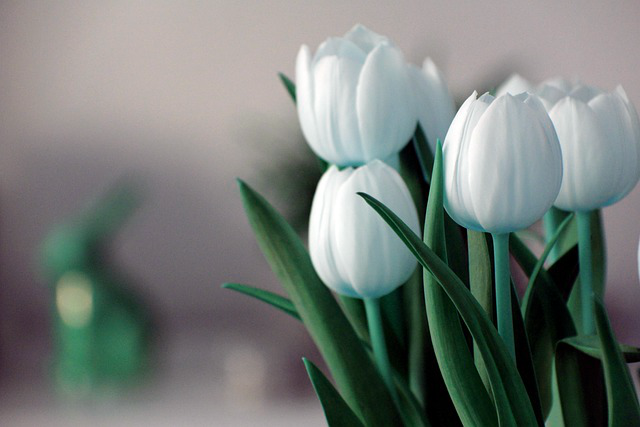

In [20]:
swap_rb = Image.merge("RGB", (b, g, r))
swap_rb


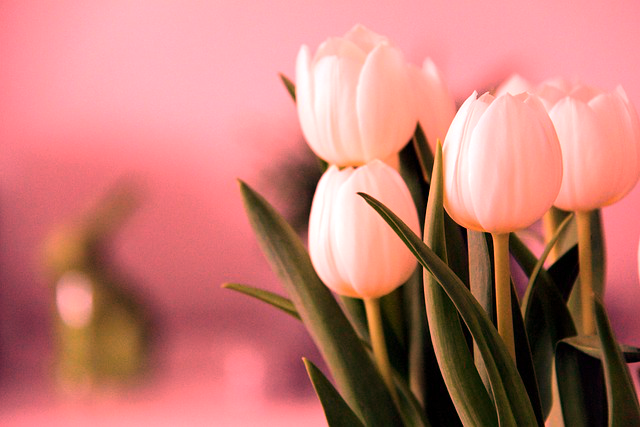

In [21]:
def double(val): 
    return min(255, val*2)

r_plus = r.point(double)
rouge_boost = Image.merge("RGB", (r_plus, g, b))
rouge_boost


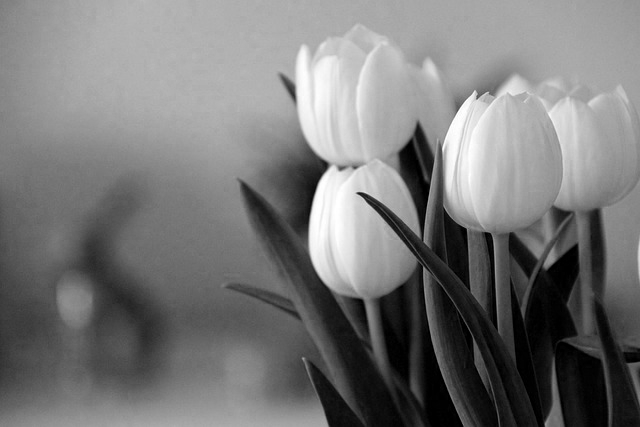

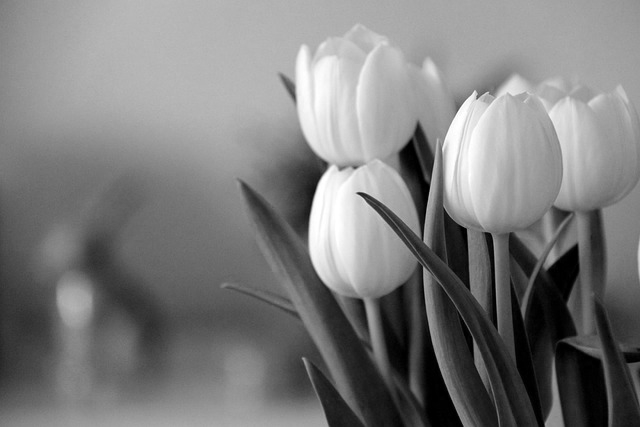

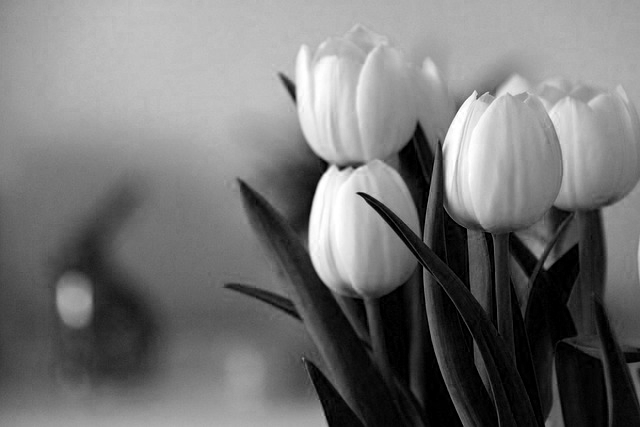

(<PIL.Image.Image image mode=L size=640x427 at 0x14C5340>, <PIL.Image.Image image mode=L size=640x427 at 0x1608660>, <PIL.Image.Image image mode=L size=640x427 at 0x1562FD8>)

In [15]:
# Séparer les 3 canaux
r, g, b = img.split()

r.show()  # canal rouge en niveaux de gris
g.show()  # canal vert
b.show()  # canal bleu

# Dans Basthon, écrire juste r, g, b permet aussi d'afficher
r, g, b


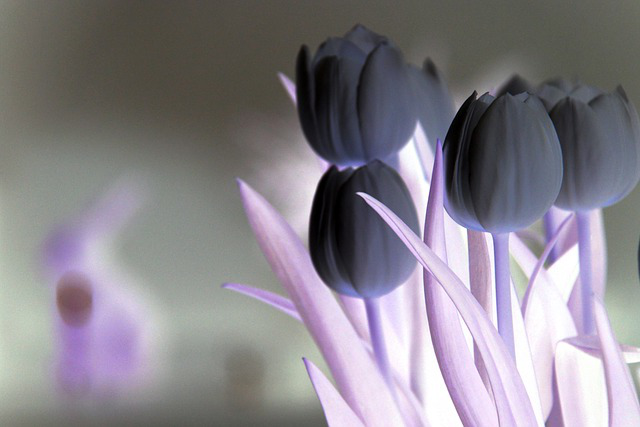

In [22]:
largeur, hauteur = img.size
negatif = Image.new("RGB", (largeur, hauteur))

for x in range(largeur):
    for y in range(hauteur):
        r0, g0, b0 = img.getpixel((x, y))
        negatif.putpixel((x, y), (255-r0, 255-g0, 255-b0))

negatif


---

#### Remarque générale

Ce document est une adaptation d'un ressource pédagogique tiré du catalogue modulo https://modulo-info.ch/. Il est sous license Creative Commons [BY-NC-SA](https://creativecommons.org/licenses/?lang=fr)
![Licence Creative Commons](https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png)